## Data Cleaning & Exploratory Data Analysis

In [1]:
import warnings 
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import re
import numpy as np

import matplotlib.pyplot as plt 
import matplotlib as mpl 
%matplotlib notebook
%pylab

import seaborn as sns
sns.set()
sns.set(font_scale=1.5)
sns.set_style('whitegrid')

Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib


In [3]:
# load data
df = pd.read_csv('raw_tweets_tesla.csv')

df.head()

,text,id,query,created_at,hashtags,symbols,retweet_count,favorite_count,in_reply_to_user_id,label
0,New video of Tesla Model S shows just how awfu...,1405281806509772800,tesla,2021-06-16 21:51:06,"[{'text': 'malysia', 'indices': [125, 133]}, {...",[],0,0,NaN,NaN
1,Welcome back to the Tesla family 👍 https://t.c...,1405281717816938500,tesla,2021-06-16 21:50:45,[],[],1,1,NaN,NaN
2,This week’s #RucaNews 👇🏻\n“Tesla works with gl...,1405281684946227202,tesla,2021-06-16 21:50:37,"[{'text': 'RucaNews', 'indices': [12, 21]}]",[],0,0,NaN,NaN
3,Bitch put gold D’s on a Tesla the most top tie...,1405281681930522630,tesla,2021-06-16 21:50:36,[],[],0,0,NaN,NaN
4,Number of Teslas registered in Norway today wa...,1405281540121141253,tesla,2021-06-16 21:50:02,"[{'text': 'Tesla', 'indices': [153, 159]}, {'t...","[{'text': 'TSLA', 'indices': [168, 173]}]",0,1,NaN,NaN


In [4]:
df.shape

(10016, 10)

In [5]:
df.nunique()

text                    9905
id                     10016
query                      1
created_at              9591
hashtags                2457
symbols                  630
retweet_count            100
favorite_count           287
in_reply_to_user_id        0
label                      0
dtype: int64

## Data cleaning

In [6]:
import nltk
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import emoji
import string
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

stopwords_set = set(stopwords.words('english'))
not_stopwords = ['not', 'nor'] 
stopwords_set = set([word for word in stopwords_set if word not in not_stopwords])
stopwords_set.add('tesla')

punctuation_set = set(string.punctuation) 
punctuation_set = punctuation_set.union(['—','“', '”', '•'])

lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

In [7]:
def tweet_cleaning(tweet):    
    #Escaping HTML characters
    tweet = BeautifulSoup(tweet).get_text()

    # general 
    tweet = ''.join(re.sub('(\d+)(st|nd|rd|th)', 'digits', tweet))
    tweet = tweet.replace('[\\t\\n\\r\\f\\v]', ' ')
    tweet = tweet.replace('-', ' ')
    tweet = tweet.replace('’', "'")
    tweet = ''.join(re.sub('US', 'United States of America', tweet))
    tweet = ''.join(re.sub('UK', 'United Kingdom', tweet))
    
    tweet = ' '.join(re.sub('(\w+:\/\/\S+)', '', tweet).split())
    tweet = ' '.join(re.sub('(@\w+)', '', tweet).split())
    
    # Removal of hashtags
    tweet = ' '.join([a for a in re.split('(#\w+).*?', tweet) if a]).replace('#','').strip() # keep words of hashtag
    
    # Split at upper case 
    tweet = ' '.join(re.findall('\d+|[A-Z]?[a-z\'?]+|[A-Z]{2,}', tweet))
   
    #Lower case
    tweet = tweet.lower()
    
    #CONTRACTIONS source: https://en.wikipedia.org/wiki/Contraction_%28grammar%29
    %run load_dict_contractions.py
    
    CONTRACTIONS = load_dict_contractions()
    words = tweet.split()
    reformed = [CONTRACTIONS[word] if word in CONTRACTIONS else word for word in words]
    tweet = " ".join(reformed)
    
    #Removal of Punctuation
    tweet = tweet.replace(":"," ")
    tweet = ''.join([i for i in tweet if i not in punctuation_set]) # on characters
    
    # Standardizing words
    tweet = ' '.join(word_tokenize(tweet)) 
    
    #Deal with emoticons source: https://en.wikipedia.org/wiki/List_of_emoticons
    %run load_dict_smileys.py 
    
    SMILEY = load_dict_smileys()  
    words = tweet.split()
    reformed = [SMILEY[word] if word in SMILEY else word for word in words]
    tweet = " ".join(reformed)
    
    #Deal with emojis
    tweet = emoji.demojize(tweet)

    # remove numbers 
    tweet = ' '.join(re.sub('\d+', '', tweet).split())
    
    # remove stopwords
    tweet = ' '.join([i for i in tweet.split() if i not in stopwords_set]) 
    
    # convert months to month_of_year
    months_list = ['january', 'february', 'march', 'april', 
                   'may', 'june', 'july', 'august', 'september',
                   'october', 'november', 'december']
    big_regex = re.compile('|'.join(map(re.escape, months_list)))
    tweet = big_regex.sub('', tweet)
    

    # remove non english
    #tweet = " ".join(w for w in word_tokenize(tweet) if w.lower() in words_set or not w.isalpha())

    # lemmatize
    #tweet = ' '.join([lemmatizer.lemmatize(word) for word in tweet.split()]) # on words
    tweet = ' '.join([stemmer.stem(word) for word in tweet.split()]) # on words
   
    return tweet

In [8]:
# process text 
df['text_clean'] = df['text'].apply(tweet_cleaning)

In [9]:
# Drop duplicates
df.sort_values('text_clean', inplace = True)
df.drop_duplicates(subset ='text_clean', keep = 'first', inplace = True) 
df.reset_index(drop=True, inplace=True)
df.shape

(7919, 11)

In [10]:
from textblob import TextBlob

def get_sentiment(dataframe, column):
    sentiment_values = [{'Polarity': v.sentiment.polarity, 
                         'Subjectivity': v.sentiment.subjectivity}
                       for v in dataframe[column].apply(TextBlob)]
    return pd.DataFrame(sentiment_values)

sent_df = get_sentiment(df, 'text_clean')

df = pd.concat([df, sent_df.Polarity], axis=1)
df.loc[df.Polarity > 0, 'textblob_label'] = 'positive'
df.loc[df.Polarity == 0, 'textblob_label'] = 'neutral'
df.loc[df.Polarity < 0, 'textblob_label'] = 'negative'

df.head()

,text,id,query,created_at,hashtags,symbols,retweet_count,favorite_count,in_reply_to_user_id,label,text_clean,Polarity,textblob_label
0,All here ... https://t.co/0fp1zEeCOL,1404696800674684928,tesla,2021-06-15 07:06:29,[],[],0,0,NaN,NaN,,0.00,neutral
1,"Maya and Ritsuko: \nLovers, Tesla Stock Owners...",1405196850085482499,tesla,2021-06-16 16:13:31,[],[],3,9,NaN,NaN,a ritsuko lover stock owner anti vaxxer,0.00,neutral
2,The 2021 AAA Car Guide overall winner is the 2...,1405264931528888326,tesla,2021-06-16 20:44:02,"[{'text': 'AAA', 'indices': [141, 145]}, {'tex...",[],0,0,NaN,NaN,aaa car guid overal winner model long rang fin...,0.15,positive
3,$AABB Company Info https://t.co/RMtaHNJQ47 \n#...,1405169048174923781,tesla,2021-06-16 14:23:02,"[{'text': 'wsj', 'indices': [44, 48]}, {'text'...","[{'text': 'AABB', 'indices': [0, 5]}]",1,1,NaN,NaN,aabb compani info wsj nytim busi reuter ih ub ...,0.00,neutral
4,$AABB News https://t.co/xAraNDdjPq \n#wsj #nyt...,1404773688164114435,tesla,2021-06-15 12:12:01,"[{'text': 'wsj', 'indices': [36, 40]}, {'text'...","[{'text': 'AABB', 'indices': [0, 5]}]",0,0,NaN,NaN,aabb news wsj nytim busi reuter ih ub stock po...,0.00,neutral


In [11]:
def convert(x):
    if x < 0:
        return 'negative'
    elif x > 0:
        return 'positive'
    else:
        return 'neutral'

In [12]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()
df['vader_polarity'] = df['text_clean'].apply(lambda x: sid.polarity_scores(x))
df['vader_label'] = df['vader_polarity'].apply(lambda x: convert(x['compound']))
df[['text', 'vader_label', 'textblob_label']]

,text,vader_label,textblob_label
0,All here ... https://t.co/0fp1zEeCOL,neutral,neutral
1,"Maya and Ritsuko: \nLovers, Tesla Stock Owners...",positive,neutral
2,The 2021 AAA Car Guide overall winner is the 2...,positive,positive
3,$AABB Company Info https://t.co/RMtaHNJQ47 \n#...,neutral,neutral
4,$AABB News https://t.co/xAraNDdjPq \n#wsj #nyt...,neutral,neutral
...,...,...,...
7914,yup theres the cavalry. Got out of the tesla p...,neutral,positive
7915,Yup but this is true🤣🤣 @elonmusk @Tesla #Tesla...,positive,positive
7916,Yup! Without a doubt! https://t.co/pit7CIVSVB,positive,neutral
7917,Zinc Sulfate Market \nhttps://t.co/zEQfkrfd1N,neutral,neutral


In [13]:
df = df[df['vader_label'] == df['textblob_label']].rename(columns={'vader_label': 'sentiment'}).drop('textblob_label', axis=1)
df.head()

,text,id,query,created_at,hashtags,symbols,retweet_count,favorite_count,in_reply_to_user_id,label,text_clean,Polarity,vader_polarity,sentiment
0,All here ... https://t.co/0fp1zEeCOL,1404696800674684928,tesla,2021-06-15 07:06:29,[],[],0,0,NaN,NaN,,0.00,"{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...",neutral
2,The 2021 AAA Car Guide overall winner is the 2...,1405264931528888326,tesla,2021-06-16 20:44:02,"[{'text': 'AAA', 'indices': [141, 145]}, {'tex...",[],0,0,NaN,NaN,aaa car guid overal winner model long rang fin...,0.15,"{'neg': 0.0, 'neu': 0.691, 'pos': 0.309, 'comp...",positive
3,$AABB Company Info https://t.co/RMtaHNJQ47 \n#...,1405169048174923781,tesla,2021-06-16 14:23:02,"[{'text': 'wsj', 'indices': [44, 48]}, {'text'...","[{'text': 'AABB', 'indices': [0, 5]}]",1,1,NaN,NaN,aabb compani info wsj nytim busi reuter ih ub ...,0.00,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",neutral
4,$AABB News https://t.co/xAraNDdjPq \n#wsj #nyt...,1404773688164114435,tesla,2021-06-15 12:12:01,"[{'text': 'wsj', 'indices': [36, 40]}, {'text'...","[{'text': 'AABB', 'indices': [0, 5]}]",0,0,NaN,NaN,aabb news wsj nytim busi reuter ih ub stock po...,0.00,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",neutral
5,$AABB Posted https://t.co/PnNhp8zx7T \n#wsj #n...,1405153694530916354,tesla,2021-06-16 13:22:01,"[{'text': 'wsj', 'indices': [38, 42]}, {'text'...","[{'text': 'AABB', 'indices': [0, 5]}]",0,0,NaN,NaN,aabb post wsj nytim busi reuter ih ub stock po...,0.00,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",neutral


<IPython.core.display.Javascript object>


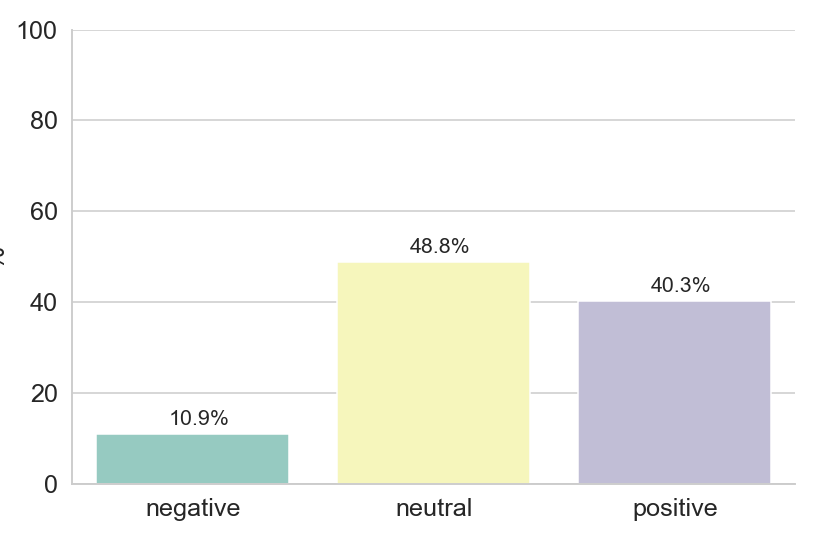

In [14]:
from collections import Counter

df_gr = df.groupby('sentiment').count()['text']
tot = df_gr.sum()
df_gr = df_gr/tot*100
df_gr = df_gr.rename('%').reset_index()

g = sns.catplot(x='sentiment', y='%', kind='bar', aspect=1.5, palette='Set3', data=df_gr)
g.ax.set_ylim(0,100)
g.ax.set_xlabel('')

for p in g.ax.patches:
    txt = str(p.get_height().round(1)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.ax.text(txt_x+0.3, txt_y+2,txt, fontsize=14)

In [15]:
def print_WordCloud(text_series, colormap):
    
    # The function accepts a pandas series containinig strings of text and 
    # generated the word frequency based WordCloud
    
    from wordcloud import WordCloud
    import nltk
    import operator
    
    text = text_series
    corpora = text.str.cat(sep=' ')
    vocabulary = nltk.word_tokenize(corpora)
    frequency = nltk.FreqDist(w for w in vocabulary) 
    frequency_dict =dict(sorted(frequency.items(), key=operator.itemgetter(1), reverse=True))
    
    wordcloud = WordCloud(
        width = 1500,
        height = 1000,
        background_color = 'Black',
        colormap=colormap,
    ).generate_from_frequencies(frequencies=frequency_dict)
    
    fig = plt.figure(
        figsize = (10, 8),
        facecolor = 'white',
        edgecolor = 'white')
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.tight_layout()

In [16]:
positive_tweets_df = df[df['sentiment'] == 'positive']
neutral_tweets_df = df[df['sentiment'] == 'neutral']
negative_tweets_df = df[df['sentiment'] == 'negative']

In [17]:
positive_tweets_df

,text,id,query,created_at,hashtags,symbols,retweet_count,favorite_count,in_reply_to_user_id,label,text_clean,Polarity,vader_polarity,sentiment
2,The 2021 AAA Car Guide overall winner is the 2...,1405264931528888326,tesla,2021-06-16 20:44:02,"[{'text': 'AAA', 'indices': [141, 145]}, {'tex...",[],0,0,NaN,NaN,aaa car guid overal winner model long rang fin...,0.150000,"{'neg': 0.0, 'neu': 0.691, 'pos': 0.309, 'comp...",positive
8,"This is absolutely awesome, thank you @Tesla! ...",1405152380728057863,tesla,2021-06-16 13:16:48,[],[],1,13,NaN,NaN,absolut awesom thank opportun work think best ...,1.000000,"{'neg': 0.0, 'neu': 0.676, 'pos': 0.324, 'comp...",positive
13,Tesla to accept bitcoin if crypto miners use m...,1404653680821944323,tesla,2021-06-15 04:15:09,[],[],0,0,NaN,NaN,accept bitcoin crypto miner use clean energi,0.366667,"{'neg': 0.0, 'neu': 0.485, 'pos': 0.515, 'comp...",positive
14,Tesla to accept #bitcoin if crypto miners use ...,1404650405133434883,tesla,2021-06-15 04:02:08,"[{'text': 'bitcoin', 'indices': [16, 24]}, {'t...",[],2,3,NaN,NaN,accept bitcoin crypto miner use clean energi e...,0.366667,"{'neg': 0.0, 'neu': 0.569, 'pos': 0.431, 'comp...",positive
15,Tesla to accept bitcoin if crypto miners use m...,1405029631422394370,tesla,2021-06-16 05:09:02,[],[],0,0,NaN,NaN,accept bitcoin crypto miner use clean energi y...,0.366667,"{'neg': 0.0, 'neu': 0.569, 'pos': 0.431, 'comp...",positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7899,The yoke may take some getting used to. We lov...,1404840633341071361,tesla,2021-06-15 16:38:02,[],[],0,25,NaN,NaN,yoke take get use love look guy think yoke dai...,0.500000,"{'neg': 0.0, 'neu': 0.704, 'pos': 0.296, 'comp...",positive
7902,Yoke ! Wao\n\nTesla's new yoke steering wheel ...,1404920266120077313,tesla,2021-06-15 21:54:28,[],[],0,0,NaN,NaN,yoke wao tesla new yoke steer wheel look super...,0.029924,"{'neg': 0.091, 'neu': 0.686, 'pos': 0.223, 'co...",positive
7903,"""A yoke is a wheel design that’s shaped that w...",1404738454014078981,tesla,2021-06-15 09:52:00,[],[],4,25,NaN,NaN,yoke wheel design shape way discourag lot turn...,0.075000,"{'neg': 0.082, 'neu': 0.82, 'pos': 0.098, 'com...",positive
7911,"Over 10yrs ago Toyota had it all, money, well ...",1405263074710495232,tesla,2021-06-16 20:36:40,[],[],0,0,NaN,NaN,yr ago toyota money well built car good reput ...,0.350000,"{'neg': 0.0, 'neu': 0.821, 'pos': 0.179, 'comp...",positive


<IPython.core.display.Javascript object>


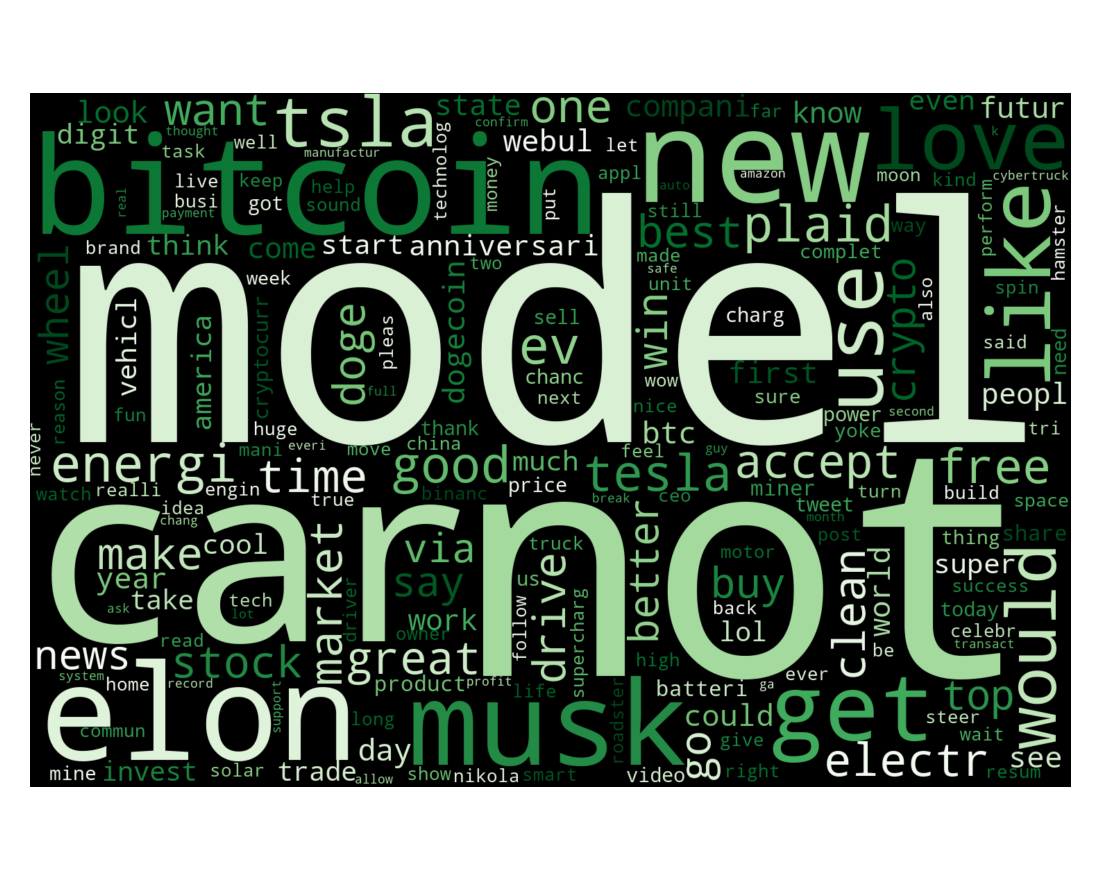

In [18]:
print_WordCloud(positive_tweets_df.text_clean, 'Greens')

<IPython.core.display.Javascript object>


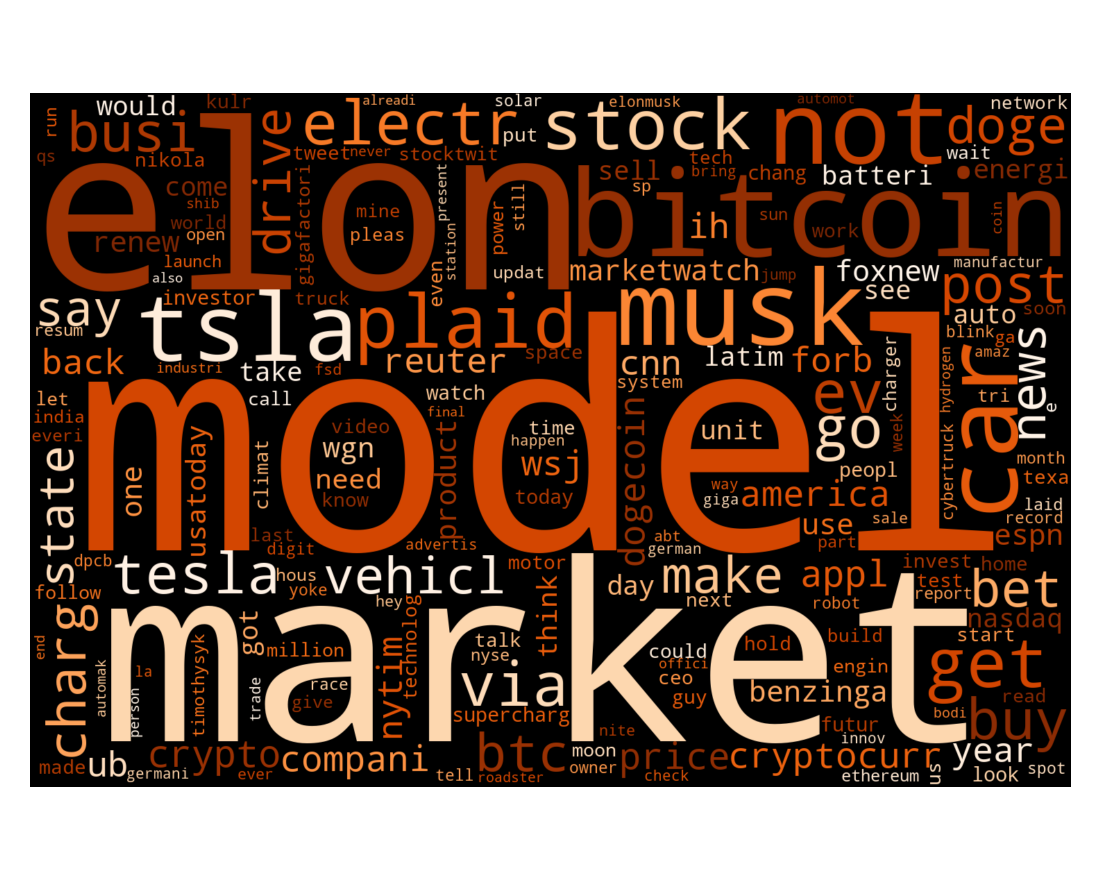

In [19]:
print_WordCloud(neutral_tweets_df.text_clean, 'Oranges')

<IPython.core.display.Javascript object>


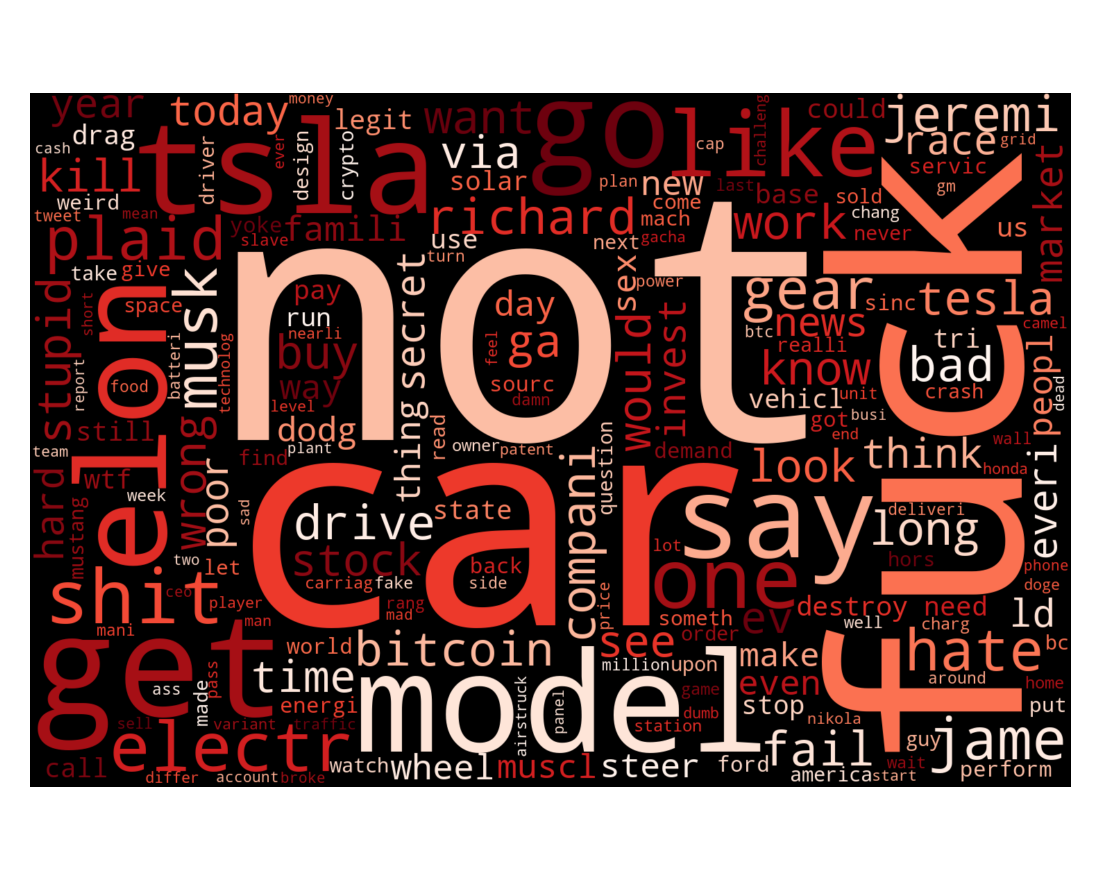

In [20]:
print_WordCloud(negative_tweets_df.text_clean, 'Reds')

In [21]:
df.to_csv('clean_tweets_tesla.csv', index=False)